In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
from matplotlib import patches
from matplotlib.ticker import FuncFormatter

from tqdm import tqdm
from time import sleep
from matplotlib import animation, rc
from IPython.display import HTML

from helpers import *

## Load fixation events

In [2]:
base_dir = '%s/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN'%os.environ['HOME']

In [4]:
ROI_radius = 100
all_fix = pd.read_csv(base_dir +
               '/Study2_EyeTracking/Data/Cleaned/Gaze_events/all_fixations_tagged_ROI_radius-%i.csv'%ROI_radius,
                     index_col = 0)
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type,10_1,10_2,S_1,T_1,T_2,S_2,5_1,5_2
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat,False,False,False,True,False,False,False,False
2,158471.0,546.94,166.93,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
3,125121.0,595.40,9.29,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
4,158525.0,703.15,112.04,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False


## Limit to payoff matrix only

In [5]:
all_fix = all_fix.loc[(all_fix['x'] >= 200) & (all_fix['x'] <= 1120) &
                      (all_fix['y'] >= 200) & (all_fix['y'] <= 950),:].reset_index(drop=True)

## Visualize

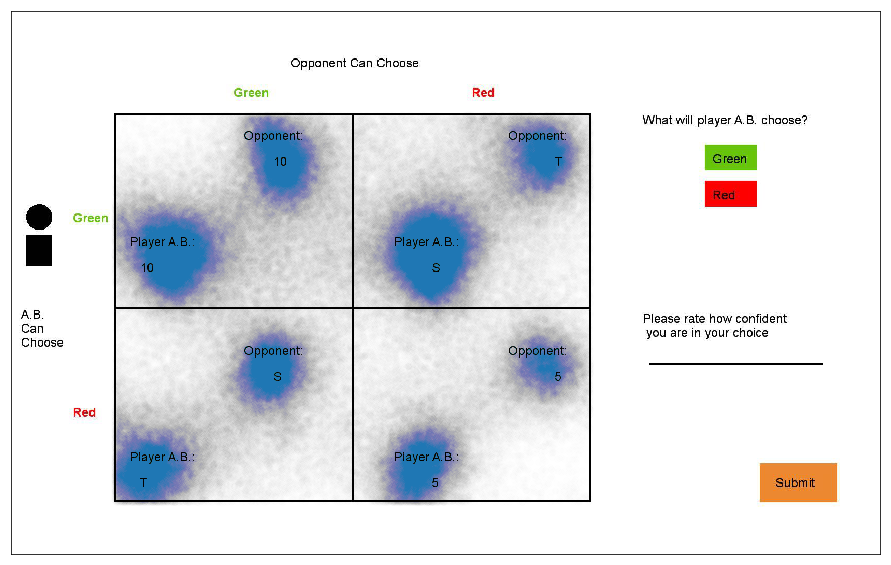

In [6]:
game_screen = image.imread('Game_screen.jpg')
fig, ax = plt.subplots(1,1,figsize = [16,10])
ax.imshow(game_screen)
ax.scatter(all_fix['x'], all_fix['y'], alpha = 0.002)
ax.set(xlim = [0,1680], ylim = [0,1050], xticks = [], yticks = [], aspect = 1);
ax.invert_yaxis()
# fig.savefig('/Users/jvanbaar/Desktop/all_fix_on_game_screen.pdf',bbox_inches='tight')

##### We are including fixations in the payoff matrix but not on a number:

In [119]:
all_fix['num'].value_counts()

no_num    105571
S_1        52074
10_1       31669
10_2       27423
S_2        26485
T_2        23790
5_1        21983
T_1        21267
5_2        15533
Name: num, dtype: int64

## Where to find first fixations?

##### I'm planning to just take the first fixation row per subject/trial/eye from all_fix. Is that accurate? Let's compare to subject's raw data files:

In [111]:
def parse_fixations_tmp(fixations):
    # empty arrays to contain fixation coordinates
    fix = {'nr':np.zeros(len(fixations)),
        'x':np.zeros(len(fixations)),
            'y':np.zeros(len(fixations)),
            'dur':np.zeros(len(fixations))}
    # get all fixation coordinates
    for fixnr in range(len(fixations)):
        nr, stime, etime, dur, ex, ey = fixations[fixnr]
        fix['x'][fixnr] = ex
        fix['y'][fixnr] = ey
        fix['dur'][fixnr] = dur
        fix['nr'][fixnr] = nr

    return fix

In [112]:
sub = 6
trials = np.arange(1,129)
eyes = ['L','R']

sub_fix = pd.DataFrame()
gaze_data_trials = parse_trials(load_data(sub, base_dir = base_dir))
fixation_events = load_fixations(sub)
for ti,trial in enumerate(trials):
    # Load raw trial data
    trial_dat = gaze_data_trials.query('trial == @trial')
    trial_start_time = trial_dat['time'].min()
    trial_end_time = trial_dat['time'].max()
    # Load trial parsed fixations
    trial_fixations = fixation_events.query('start >= %i & end <= %i'%(
        trial_start_time, trial_end_time)).copy()
    # Parse eye from string
    trial_fixations['eye'] = trial_fixations['event_type'].apply(lambda x: x[-1])
    trial_fixations = trial_fixations[['eye','number','start','end','duration','X','Y']].reset_index(drop=True)
    for ei,eye in enumerate(eyes):
        fix = pd.DataFrame(parse_fixations_tmp(trial_fixations.query('eye == @eye').iloc[:,1:].values))
        fix['sub'] = sub
        fix['trial'] = trial
        fix['eye'] = eye
        sub_fix = sub_fix.append(fix).reset_index(drop=True)

Loading files:
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_full_info/sub-006_ses-001_part1 Samples.txt
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_full_info/sub-006_ses-001_part2 Samples.txt
Raw data shape is (136342, 8)
Raw data shape is (89124, 8)
Processed data shape is (225304, 12)
Loading files:
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-006_ses-001_part1 Events.txt
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-006_ses-001_part2 Events.txt
[1, 1] [1, 2]
Raw data shape is (16333, 17)
Raw data shape is (10719, 17)


In [114]:
lowest_nr = np.min(sub_fix.nr)
sub_fix.query('nr == @lowest_nr')

,dur,nr,x,y,sub,trial,eye
0,267012.0,69.0,786.31,490.46,6,1,L


##### Now compare this with the fixations obtained through preprocessing

In [115]:
all_fix.query('sub == 6').iloc[0,:].head()

dur      267012
x        786.31
y        490.46
sub           6
trial         1
Name: 4704, dtype: object

##### Ok, that checks out.

## Grab first fixations - all numbers

In [122]:
first_fix = pd.DataFrame()
for sub in all_fix['sub'].unique():
    print(sub, end=',')
    for trial in np.arange(1,129):
        for eye in ['L','R']:
            tmp = all_fix.query('sub == @sub & trial == @trial & eye == @eye')
            if len(tmp) > 0:
                tmp = tmp.iloc[0]
                first_fix = first_fix.append(tmp)

5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,

In [123]:
first_fix = first_fix.reset_index(drop=True)[
    ['sub','part','player_type','trial','eye',
     'x','y','num','num_S_T','dur']]

In [124]:
first_fix.head()

,sub,part,player_type,trial,eye,x,y,num,num_S_T,dur
0,5.0,1.0,opt_nat,1.0,L,719.21,453.20,S_1,S,183522.0
1,5.0,1.0,opt_nat,1.0,R,724.17,331.65,no_num,no_S_T,150130.0
2,5.0,1.0,opt_nat,2.0,L,849.86,341.23,no_num,no_S_T,158516.0
3,5.0,1.0,opt_nat,2.0,R,848.71,250.96,no_num,no_S_T,158516.0
4,5.0,1.0,opt_nat,3.0,L,936.41,385.22,no_num,no_S_T,125136.0


##### Store

In [125]:
first_fix.to_csv(base_dir +
                '/Study2_EyeTracking/Data/Cleaned/Gaze_events/'+
                'first_fixations_tagged_ROI_radius-%i.csv'%ROI_radius)

## Grab first fixations - between S and T only (priority)

In [126]:
first_fix_S_T = pd.DataFrame()
for sub in all_fix['sub'].unique():
    print(sub, end=',')
    for trial in np.arange(1,129):
        for eye in ['L','R']:
            tmp = all_fix.loc[(all_fix['S'] | all_fix['T'])
                              & (all_fix['sub'] == sub)
                              & (all_fix['trial'] == trial)
                              & (all_fix['eye'] == eye),:]
            if len(tmp) > 0:
                tmp = tmp.iloc[0]
                first_fix_S_T = first_fix_S_T.append(tmp)

5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,

In [127]:
first_fix_S_T = first_fix_S_T.reset_index(drop=True)[
    ['sub','part','player_type','trial','eye',
     'x','y','num','num_S_T','dur']]

In [128]:
first_fix_S_T.head()

,sub,part,player_type,trial,eye,x,y,num,num_S_T,dur
0,5.0,1.0,opt_nat,1.0,L,719.21,453.20,S_1,S,183522.0
1,5.0,1.0,opt_nat,1.0,R,1041.80,266.83,T_1,T,100111.0
2,5.0,1.0,opt_nat,2.0,L,776.42,464.59,S_1,S,150097.0
3,5.0,1.0,opt_nat,2.0,R,253.51,894.87,T_2,T,208593.0
4,5.0,1.0,opt_nat,3.0,L,774.59,427.13,S_1,S,108376.0


##### Store

In [129]:
first_fix_S_T.to_csv(base_dir +
                '/Study2_EyeTracking/Data/Cleaned/Gaze_events/'+
                'S_T_priority_ROI_radius-%i.csv'%ROI_radius)